Dialogue systems use a variety of mechanisms to carryout informative and coherent conversations withtheir users.   These conversations can be achieved through rule-basd,  template-based, retrieval-based approaches or in a data-driven manner that teaches the agent to learn from raw conversational data. This workshop will focus on the retreival-based method. 

## Retreival-Based Chatbot
A retrieval-based agent or chatbot retrieves related responses from queries in the corpus that are similar to the given query.  We are not interested in generating a new response, but select the most suitable response (originally made to other queries) as reply to the current query. We will be try to do this by having a set of questions with labelled intents and then try to classify the intent.

### Accessing Colab

- Sign in to you Google account.
- Access the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true) and click on ‘Github’. In the ‘Enter a GitHub URL or search by organization or user’ line enter `https://github.com/bespoke-inc/bespoke-public-talks`. We will be using the notebook in folder `2020/2020-08-22-MLT-Rules-to-DL`
- You need to tell Colab that you are interested in using a GPU. You can do this by clicking on the `Runtime` tab and selecting `Change runtime type`. A pop-up window will appear. Select `GPU` from the menu and `Save`.
- Save your work to Google Drive by clicking on ‘File’ and then ‘Save’ and then `SAVE A COPY IN DRIVE.` in the pop-up.

In [1]:
#install the necessary dependencies by uncommenting and running the following commands:
#!wget https://raw.githubusercontent.com/bespoke-inc/bespoke-public-talks/master/2020/2020-08-22-MLT-Rules-to-DL/requirements.txt
#!pip install -r requirements.txt

### Workshop Task #1: Create a corpus

The first task will be making your own training data based on the above format. We will work a small dataset that we've provided and later some publicly available ones but participants are expected to create their own for this part of the workshop

## Training Data
This is a sample format of the training data we want to use:

```
training_phrases = {
        'when_is_check_in' : ['when is check-in','When can I check in?','when's checkin'],
        'where_is_the_front_desk' : ['Where is the front desk?','what is the location of the front desk?'...]}
}

answers : {
        'when_is_check_in' : 'Check in is at 3pm! :)',
        'where_is_the_front_desk' : 'The front desk is located on the 2nd floor.'}
```

In [1]:
import pandas as pd
import json

In [3]:
#get training data
#!wget https://raw.githubusercontent.com/bespoke-inc/bespoke-public-talks/master/2020/2020-08-22-MLT-Rules-to-DL/training_sample.json

In [2]:
training_data = json.load(open('./training_sample.json','r'))

In [3]:
list(training_data.keys())

['hotel.when_is_check_in',
 'hotel.when_is_check_out',
 'hotel.is_there_early_check_in',
 'hotel.is_there_late_check_out',
 'hotel.where_is_the_front_desk_located']

In [4]:
answers = {
    'hotel.when_is_check_in': 'Check in is at 3pm!',
    'hotel.when_is_check_out': 'Check out is at 10am!',
    'hotel.is_there_late_check_out': 'For early check-out or late check-in please schedule beforehand',
    'hotel.is_there_early_check_in': 'For early check-out or late check-in please schedule beforehand',
    'hotel.where_is_the_front_desk_located': 'Front desk is located on the 2nd floor'
    }

In [5]:
import re

In [6]:
punct_re_escape = re.compile('[%s]' % re.escape('!"#$%&()*+,./:;<=>?@[\\]^_`{|}~'))

class MyChatbotData:
    
    def __init__(self, json_obj, text_fld, answers):
        dfs = []
        for i, (intent, data) in enumerate(json_obj.items()):
            # lowercase and remove punctuation
            patterns = data[text_fld].copy()
            for i, p in enumerate(patterns):
                p = p.lower()
                p = self.remove_punctuation(p)
                patterns[i] = p
                answer = answers[intent]
            df = pd.DataFrame(list(zip([intent]*len(patterns), patterns, [answer]*len(patterns))), \
                              columns=['intent', 'phrase', 'answer'])
            dfs.append(df)
        self.df = pd.concat(dfs)
    
    def get_answer(self, intent):
        return pd.unique(self.df[self.df['intent'] == intent]['answer'])[0]
    
    def remove_punctuation(self, text):
        return punct_re_escape.sub('', text)
    
    def get_phrases(self, intent):
        return list(self.df[self.df['intent'] == intent]['phrase'])
    
    def get_intents(self):
        return list(pd.unique(self.df['intent']))
    
    def show_batch(self, size=5):
        return self.df.head(size)
    
    def __len__(self):
        return len(self.df)

In [7]:
chatbot_data = MyChatbotData(training_data, 'patterns', answers)

In [8]:
chatbot_data.show_batch(10)

,intent,phrase,answer
0,hotel.when_is_check_in,when is check-in,Check in is at 3pm!
1,hotel.when_is_check_in,how to check in,Check in is at 3pm!
2,hotel.when_is_check_in,what time is the latest we can check into the ...,Check in is at 3pm!
3,hotel.when_is_check_in,what time is check in open till,Check in is at 3pm!
4,hotel.when_is_check_in,can you advise the check in time,Check in is at 3pm!
5,hotel.when_is_check_in,what time is check in for new hotel otani toky...,Check in is at 3pm!
6,hotel.when_is_check_in,late check in,Check in is at 3pm!
7,hotel.when_is_check_in,can i check in late,Check in is at 3pm!
8,hotel.when_is_check_in,what about check in,Check in is at 3pm!
9,hotel.when_is_check_in,im down to check in,Check in is at 3pm!


In [9]:
len(chatbot_data)

368

## Rule-based intent ~~classification~~ matching

The simplest approach to find if an query falls into a certain intent is to do some string comparison with our dataset. 

In [10]:
UNK = "I don't know"

In [11]:
def exact_match(query):
    intents = chatbot_data.get_intents()
    for i in intents:
        phrases = chatbot_data.get_phrases(i)
        if query in phrases:
            return chatbot_data.get_answer(i)
    return UNK

In [12]:
exact_match("is there early check-in")

'For early check-out or late check-in please schedule beforehand'

In [13]:
exact_match("when do i check in")

'Check in is at 3pm!'

In [14]:
exact_match("can i check-in earlier than 12pm")

"I don't know"

## Preprocessing

- CJK
- normalize contractions
- remove hyphens
- remove stopwords
- check for typos
- normalize plurals
- normalize ascii
- normalize emojis
- remove punctuation



In [12]:
import re

EMOJIS = [[':)', '😀'],[';)', '😉'],[':(', '😞'],[';((', '😢'],[':p', '😛']]
_emoji_re = '[\U00010000-\U0010ffff]+'
emoji_re = re.compile(_emoji_re, flags=re.UNICODE)

def emoji_normalize(text):
    for e1, e2 in EMOJIS:
        text = text.replace(e1, e2)
    return text

def is_emoji(text):
    emoji = "".join(re.findall(_emoji_re, text))
    return emoji == text

def emoji_isolate(text):
    EMJ = "__EMOJI__"
    emoji_list = re.findall(_emoji_re, text)
    text = emoji_re.sub(f" {EMJ} ", text)
    new_str, ctr = [], 0
    for tok in text.split():
        if tok == EMJ:
            new_str.append(emoji_list[ctr])
            ctr += 1
        else:
            new_str.append(tok)
    return " ".join(new_str).strip()

In [13]:
import unicodedata

def ascii_normalize(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode("utf-8") 

In [14]:
punct_re_escape = re.compile('[%s]' % re.escape('!"#$%&()*+,./:;<=>?@[\\]^_`{|}~'))

def remove_punctuation(text):
    punct_re_escape.sub('', text)

In [15]:
def preprocess(text):
    text = ascii_normalize(text) or text
    text = emoji_normalize(text) or text
    text = emoji_isolate(text) or text
    text = remove_punctuation(text) or text
    return text

### Workshop Task #2: Further preprocessing steps
Add other types of preprocessing relevant to the dataset you created. It could be from any of the ones listed above

### Partial String Matching
Instead of checking is the entire query string exists in our dataset, we try to find a partial match
and pick the intent that matches most closely. We will try to do this with using Levenshtein Distance 
to calculate the differences between sequences. The library [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy)
can help us do this

In [16]:
from fuzzywuzzy import process

In [17]:
def fuzzy_matching(query):
    intents = chatbot_data.get_intents()
    for i in intents:
        phrases = chatbot_data.get_phrases(i)
        match, score = process.extractOne(query, phrases)
        if score > 90:
            return chatbot_data.get_answer(i)
    return UNK

In [21]:
fuzzy_matching("when do i check-in")

'Check in is at 3pm!'

In [22]:
fuzzy_matching("can i check-in earlier than 12pm")

'For early check-out or late check-in please schedule beforehand'

In [23]:
fuzzy_matching("what time is early check-in")

'Check in is at 3pm!'

## ML Classification
We will now add a probabilistic classifier to our set of methods to get better intent classification.
The algorithm we will use is [naive bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)

Naive Bayes classifiers works quite well for small amount of training data.

### Tokenizer
Before we feed it to our model for training we need to tokenize our training instances

In [18]:
import spacy

In [19]:
nlp = spacy.load('en_core_web_sm',parse=False,tagger=False)

In [26]:
doc = nlp("when can i check in?")
[tok.text for tok in doc]

['when', 'can', 'i', 'check', 'in', '?']

In [27]:
doc = nlp("when can i check-in?")
[tok.text for tok in doc]

['when', 'can', 'i', 'check', '-', 'in', '?']

In [28]:
doc = nlp("i didn't")
[tok.text for tok in doc]

['i', 'did', "n't"]

In [29]:
doc = nlp("thank you ありがとう")
[tok.text for tok in doc]

['thank', 'you', 'ありがとう']

In [30]:
doc = nlp("didn't    couldn't   ")
[tok.text for tok in doc if tok.text.strip()]

['did', "n't", 'could', "n't"]

In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/asirsaeed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [21]:
def tokenize_nd_join(text):
    doc = nlp(text.lower())
    return " ".join(tok.text for tok in doc if tok.text.strip() not in stopwords)

In [22]:
def get_xs_ys(train_data):
    x, y = [], []
    intents = chatbot_data.get_intents()
    for i in intents:
        phrases = chatbot_data.get_phrases(i)
        x += [tokenize_nd_join(phrase) for phrase in phrases]
        y += [i]*len(phrases)
    return x, y

In [23]:
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [24]:
def train(x,y):
    vect = CountVectorizer(ngram_range=(1,2),max_features=None)
    nb = Pipeline([('vect',vect),('clf',ComplementNB(alpha=1.0,norm=False))])
    nb.fit(x,y)
    return nb

In [27]:
x, y = get_xs_ys(training_data)
nb_model = train(x, y)

In [28]:
def nb_pred(query):
    tokenized_query = tokenize_nd_join(query)
    pred = nb_model.predict([tokenized_query])[0]
    return chatbot_data.get_answer(pred)

In [29]:
nb_pred("what time is early check-in")

'For early check-out or late check-in please schedule beforehand'

In [30]:
import numpy as np

In [31]:
def nb_pred_top3(query):
    tokenized_query = tokenize_nd_join(query)
    pred_prob = nb_model.predict_proba([tokenized_query])
    preds_sorted = np.argsort(pred_prob)
    top3 = preds_sorted[:,-1],preds_sorted[:,-2],preds_sorted[:,-2]
    if pred_prob[0,top3[0]] > (pred_prob[0,top3[1]] + pred_prob[0,top3[2]]):
        pred = nb_model.named_steps['clf'].classes_[top3[0]][0]
        return chatbot_data.get_answer(pred)
    return UNK
    

In [41]:
nb_pred_top3("is there early check-in")

'For early check-out or late check-in please schedule beforehand'

## Intent Classification Pipeline

In [32]:
def get_pred(query):
    query = query.lower()
    pred = exact_match(query)
    if pred == UNK: pred = exact_match(preprocess(query))
    if pred == UNK: pred = nb_pred_top3(query)
    if pred == UNK: pred = nb_pred_top3(preprocess(query))
    if pred == UNK: pred = fuzzy_matching(query)
    if pred == UNK: pred = fuzzy_matching(preprocess(query))
    return pred

In [43]:
get_pred("when is check-in")

'Check in is at 3pm!'

In [44]:
get_pred("can i check-out late?")

'For early check-out or late check-in please schedule beforehand'

In [45]:
get_pred("where can i find the front desk?")

'Front desk is located on the 2nd floor'

### Moving ML to DL
We see that this pipeline using some rules and a probabilistic model are working quite well.
However, it doesn't scale with data and requires adding a lot of preprocessing and nuances to get working properly

Pros:
- There are noticeable improvement in using NNs over the current probabilistic model.
- Model can scale with data i.e it can improve as we add more annotated training data
- This can be a good point to move to NNs, since we are reaching the limits of rule based systems e.g fewer engineered features
- Simplified pipeline

Cons:
- Huge gains cannot be seen until the data is cleaned. 
- In its current state, the model will either be the same or slightly better than the current approach.
- Infrastructure changes

## Classification with Distil Bert

In [33]:
from fastai import *
from fastai.text import *

In [34]:
answers = {
    'hotel.when_is_check_in': 'Check in is at 3pm!',
    'hotel.when_is_check_out': 'Check out is at 10am!',
    'hotel.is_there_late_check_out': 'For early check-out or late check-in please schedule beforehand',
    'hotel.is_there_early_check_in': 'For early check-out or late check-in please schedule beforehand',
    'hotel.where_is_the_front_desk_located': 'Front desk is located on the 2nd floor'
    }

In [35]:
class MyChatbotData:
    
    def __init__(self, json_obj, text_fld, answers):
        dfs = []
        for i, (intent, data) in enumerate(json_obj.items()):
            # lowercase and remove punctuation
            patterns = data[text_fld].copy()
            for i, p in enumerate(patterns):
                p = p.lower()
                p = self.remove_punctuation(p)
                patterns[i] = p
                answer = answers[intent]
            df = pd.DataFrame(list(zip([intent]*len(patterns), patterns, [answer]*len(patterns))), \
                              columns=['intent', 'phrase', 'answer'])
            dfs.append(df)
        self.df = pd.concat(dfs)
    
    def get_answer(self, intent):
        return pd.unique(self.df[self.df['intent'] == intent]['answer'])[0]
    
    def remove_punctuation(self, text):
        return punct_re_escape.sub('', text)
    
    def get_phrases(self, intent):
        return list(self.df[self.df['intent'] == intent]['phrase'])
    
    def get_intents(self):
        return list(pd.unique(self.df['intent']))
    
    def show_batch(self, size=5):
        return self.df.head(size)
    
    def __len__(self):
        return len(self.df)

In [36]:
training_data = json.load(open('./training_sample.json','r'))

In [37]:
list(training_data.keys())

['hotel.when_is_check_in',
 'hotel.when_is_check_out',
 'hotel.is_there_early_check_in',
 'hotel.is_there_late_check_out',
 'hotel.where_is_the_front_desk_located']

In [38]:
chatbot_data = MyChatbotData(training_data, 'patterns', answers)

In [39]:
df = chatbot_data.df
df.head()

,intent,phrase,answer
0,hotel.when_is_check_in,when is check-in,Check in is at 3pm!
1,hotel.when_is_check_in,how to check in,Check in is at 3pm!
2,hotel.when_is_check_in,what time is the latest we can check into the ...,Check in is at 3pm!
3,hotel.when_is_check_in,what time is check in open till,Check in is at 3pm!
4,hotel.when_is_check_in,can you advise the check in time,Check in is at 3pm!


Since the sample dataset may be bit too small for this part of the workshop we will be using a public one
from [here](https://www.kaggle.com/hassanamin/atis-airlinetravelinformationsystem/data)

In [50]:
df = pd.read_csv("284285_585165_bundle_archive/atis_intents.csv",header=0,names=['intent', 'phrase'])
df.head()

,intent,phrase
0,atis_flight,what flights are available from pittsburgh to...
1,atis_flight_time,what is the arrival time in san francisco for...
2,atis_airfare,cheapest airfare from tacoma to orlando
3,atis_airfare,round trip fares from pittsburgh to philadelp...
4,atis_flight,i need a flight tomorrow from columbus to min...


In [51]:
len(set(df['intent'])), len(df)

(22, 4977)

In [52]:
path = Path('./')

Adapting fastai code for training transformers was inspired from this [blog post](https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2)

In [40]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import PreTrainedTokenizer

In [41]:
class TransformersBaseTokenizer(BaseTokenizer):
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        tokens = [CLS] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + [SEP]
        return tokens

In [42]:
transformer_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [43]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
        
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [44]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, 
                                       include_bos=False, 
                                       include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [45]:
pad_idx = transformer_tokenizer.pad_token_id

databunch = (TextList.from_df(df, cols='phrase', processor=transformer_processor)
             .split_by_rand_pct()
             .label_from_df(cols= 'intent')
             .databunch(bs=64, pad_first=False, pad_idx=pad_idx))

In [46]:
class TransformerModel(nn.Module):
  
    def __init__(self, transformer):
        super(TransformerModel,self).__init__()
        self.transformer = transformer
        
    def forward(self, input_ids):
        # Return only the logits from the transfomer
        logits = self.transformer(input_ids)[0]   
        return logits

In [47]:
config = DistilBertConfig.from_pretrained('distilbert-base-uncased')
config.num_labels = databunch.train_ds.c

distil_bert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)
transformer_model = TransformerModel(distil_bert)

In [48]:
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learn = Learner(databunch, transformer_model, opt_func = CustomAdamW, metrics=[accuracy])

In [49]:

list_layers = [learn.model.transformer.base_model.embeddings,
               learn.model.transformer.base_model.transformer.layer[0],
               learn.model.transformer.base_model.transformer.layer[1],
               learn.model.transformer.base_model.transformer.layer[2],
               learn.model.transformer.base_model.transformer.layer[3],
               learn.model.transformer.base_model.transformer.layer[4],
               learn.model.transformer.base_model.transformer.layer[5],
               learn.model.transformer.pre_classifier,
               learn.model.transformer.classifier]
               
learn.split(list_layers);

In [50]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


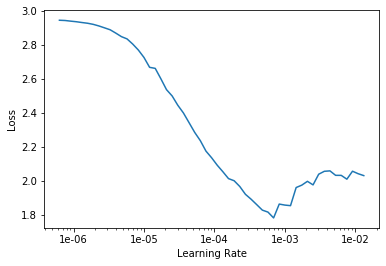

In [65]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(3,max_lr=1e-3,moms=(0.8,0.7))

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(8e-4/(2.6**4),8e-4), moms=(0.8,0.7))

In [ ]:
learn.freeze_to(-5)
learn.fit_one_cycle(2, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7))

In [ ]:
learn.freeze_to(-8)
learn.fit_one_cycle(2, slice(3e-4/(2.6**4),3e-4), moms=(0.8,0.7))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

In [125]:
learn.predict("what flights are available from pittsburgh to baltimore")

In [ ]:
interp = TextClassificationInterpretation(learn,*learn.get_preds(with_loss=True))

In [ ]:
interp.show_top_losses(20)

### Workshop Task 3: Using Named Entity Recognition to extract parameters (10 min)
Generalizing your training data with entity classes
Add named entities to one intent and use spaCy to extract

In [51]:
class ParameterModel():
    
    def __init__(self, param_list):
        self.parameters = param_list
        self.label_ = 'PARAM'
    
    def replace_entities(self, text):
        """Replace entities in the text with their respective labels"""
        entity_replaced_text = text
        for p in self.parameters:
            if p in text:
                entity_replaced_text = text.replace(p, f'<__{self.label_}__>')
        return entity_replaced_text

In [52]:
food_list = ['japanese','indian','thai','chinese','fast food','bbq','cafe']
food_param_model = ParameterModel(food_list) 

In [53]:
food_param_model.replace_entities("I want fast food")

'I want <__PARAM__>'

In [54]:
MODEL_NAME = 'en_core_web_md'

class SpacyModel(object):
    spacy_model = None  # Where we keep the model when it's loaded

    @classmethod
    def get_base_spacy_model(cls):
        """Get the base spacy model"""
        if not cls.spacy_model:
            cls.spacy_model = spacy.load(MODEL_NAME)
        return cls.spacy_model
    
    @classmethod
    def replace_entities(cls, text):
        """Replace entities in the text with their respective labels"""
        spacy_model = cls.get_base_spacy_model()
        doc = spacy_model(text)
        entity_replaced_text = text
        for e in reversed(doc.ents):
            start = e.start_char
            end = start + len(e.text)
            entity_replaced_text = entity_replaced_text[:start] + f'<__{e.label_}__>' + entity_replaced_text[end:]
        return entity_replaced_text

In [55]:
SpacyModel.replace_entities("how do i get to shibuya")

'how do i get to <__GPE__>'

In [56]:
SpacyModel.replace_entities("can i get a reservation for Sunday")

'can i get a reservation for <__DATE__>'

### Workshop Task 4: Using users to disambiguate intents (10 min)
When two intents are good candidates for the user's text, instead of picking the best, ask the user which they meant.
Add disambiguation ability in your bot

### Workshop Task 5: Typos (10 min)
Since users are typing in their text, errors are common. Hence, the bot must be resilient to typos
Add typo correction in your bot

## Putting it all together

In [57]:
def replace_entities(text):
    entity_replaced = SpacyModel.replace_entities(text)
    entity_replaced = food_param_model.replace_entities(entity_replaced)
    return entity_replaced

In [58]:
class TextFactory:

    def __init__(self, text):
        self.raw = text
        self._sanitized = None
        self._entity_replaced = None
        self._sanitized_and_entity_replaced = None

    def sanitized(self):
        if not self._sanitized:
            self._sanitized = preprocess(self.raw)
        return self._sanitized
    
    def entity_replaced(self):
        if not self._entity_replaced:
            self._entity_replaced = replace_entities(self.raw)
        return self._entity_replaced

    def typo_corrected(self):
        #if not self._typo_corrected:
        #    self._typo_corrected = typo_correct(self.raw)
        #return self._typo_corrected
        pass

    def sanitized_and_entity_replaced(self):
        if not self._sanitized_and_entity_replaced:
            self._sanitized_and_entity_replaced = replace_entities(self.sanitized())
        return self._sanitized_and_typo_corrected

In [59]:
class ClassifierBuilder:

    def __init__(self, query):
        self.raw_query = query
        self.queries = []
        self.classifiers = []
    
    def add_classifiers_query(self, classifier, query):
        self.classifiers.append(classifier)
        self.queries.append(query)
        return self
    
    def build(self):
        # validation
        if not self.classifiers:
            raise Exception('Must specify classifiers')
        # build
        preds = None
        for c in self.classifiers:
            pred = c.predict(self.raw_query)
            if pred != UNK:
                return pred
        return pred

In [60]:
class MyChatbotData:
    
    def __init__(self, json_obj, text_fld, answers):
        dfs = []
        for i, (intent, data) in enumerate(json_obj.items()):
            # lowercase and remove punctuation
            patterns = data[text_fld].copy()
            for i, p in enumerate(patterns):
                p = p.lower()
                patterns[i] = p
                answer = answers[intent]
            df = pd.DataFrame(list(zip([intent]*len(patterns), patterns, [answer]*len(patterns))), \
                              columns=['intent', 'phrase', 'answer'])
            dfs.append(df)
        self.df = pd.concat(dfs)
    
    def get_answer(self, intent):
        return pd.unique(self.df[self.df['intent'] == intent]['answer'])[0]
    
    def remove_punctuation(self, text):
        return punct_re_escape.sub('', text)
    
    def get_phrases(self, intent):
        return list(self.df[self.df['intent'] == intent]['phrase'])
    
    def get_intents(self):
        return list(pd.unique(self.df['intent']))
    
    def show_batch(self, size=5):
        return self.df.head(size)
    
    def __len__(self):
        return len(self.df)

In [61]:
class ExactMatch:
    
    def __init__(self, data):
        self.data = data

    def predict(self, query):
        intents = self.data.get_intents()
        for i in intents:
            phrases = self.data.get_phrases(i)
            if query in phrases:
                return i
        return UNK

In [62]:
class FuzzyMatch:

    def __init__(self, data):
        self.data = data
    
    def predict(self, query):
        intents = self.data.get_intents()
        for i in intents:
            phrases = self.data.get_phrases(i)
            match, score = process.extractOne(query, phrases)
            if score > 90:
                return chatbot_data.get_answer(i)
        return UNK

In [66]:
class NaiveBayesMatch:
    
    def __init__(self, data, model):
        self.data = data
        self.nb_model = model
        
    def predict(self, query):
        tokenized_query = tokenize_nd_join(query)
        pred_prob = nb_model.predict_proba([tokenized_query])
        preds_sorted = np.argsort(pred_prob)
        top3 = preds_sorted[:,-1],preds_sorted[:,-2],preds_sorted[:,-2]
        if pred_prob[0,top3[0]] > (pred_prob[0,top3[1]] + pred_prob[0,top3[2]]):
            pred = nb_model.named_steps['clf'].classes_[top3[0]][0]
        return pred

In [64]:
class DistilBertMatch:
    def __init__(self, data, learner):
        self.data = data
        self.learner = learner
    
    def predict(self, query):
        pred, idx, probs = self.learner.predict(query)
        return pred

In [67]:
exact_match_classifier = ExactMatch(chatbot_data)
fuzzy_match_classifier = FuzzyMatch(chatbot_data)
naive_bayes_classifier = NaiveBayesMatch(chatbot_data, nb_model)
distil_bert_classifier = DistilBertMatch(chatbot_data, learn)

In [68]:
class Predictor:
    def __init__(self, query):
        self.text_factory = TextFactory(query)
        self.pipeline = ClassifierBuilder(query)

    def predict(self):
        pred = self.pipeline.add_classifiers_query(exact_match_classifier, self.text_factory.raw) \
                            .add_classifiers_query(exact_match_classifier, self.text_factory.sanitized()) \
                            .add_classifiers_query(exact_match_classifier, self.text_factory.entity_replaced()) \
                            .add_classifiers_query(distil_bert_classifier, self.text_factory.raw) \
                            .add_classifiers_query(distil_bert_classifier, self.text_factory.sanitized()) \
                            .add_classifiers_query(distil_bert_classifier, self.text_factory.entity_replaced()) \
                            .add_classifiers_query(fuzzy_match_classifier, self.text_factory.raw) \
                            .build()
        return pred

In [69]:
predictor = Predictor("what time is check-in")
predictor.predict()

'hotel.when_is_check_in'

### Workshop Task 5: Put together a pipeline for your bot (10 min)